Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

import matplotlib.pyplot as plt
import os

# set up initial path to data
DATADIR = os.path.join("sample-data","data")
game_id = 2 # let's look at sample match 2

Import Metrics

In [3]:
import Metrica_IO as mio
import Metrica_Viz as mviz

In [4]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

Reading team: home
Reading team: away


Merge the two tracking DataFrames based on the 'Time [s]' column, which is common to both

In [5]:
tracking_data = pd.merge(tracking_away, tracking_home, on='Time [s]', how='outer')

# Sort the combined DataFrame by the 'Time [s]' column
tracking_data = tracking_data.sort_values(by='Time [s]')

# Reset the index of the combined DataFrame
tracking_data.reset_index(drop=True, inplace=True)

# fill NaN values with 0:
tracking_data.fillna(0, inplace=True)
tracking_data.drop(['ball_x_x', 'ball_y_x', 'Period_y'], axis=1, inplace=True)
tracking_data.rename(columns={'ball_x_y': 'ball_x', 'ball_y_y': 'ball_y', 'Period_x': 'Period'}, inplace=True)
tracking_data
tracking_data.to_csv('tracking_data.csv', index=False)

In [6]:
events.to_csv('events.csv', index=False)

In [7]:
# dimensions of the field: 105x68 meters.

home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2))]
home_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [8]:
home_moments.to_csv('home_moments.csv', index=False)

In [9]:
home_moments.columns.get_loc('Home_11_x')

26

Find Home Team High Pressure moment #1

In [10]:
import numpy as np

a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

# Loop through each row and calculate the distance for each player
for index, row in home_moments.iterrows():
    distances_away = []
    distances_home = []
    ball_x = row['ball_x']
    ball_y = row['ball_y']

    for a_player in a_players:
        # Get the index of the current player column
        a_index = row.index.get_loc(a_player)
        away_x = row.iloc[a_index]
        away_y = row.iloc[a_index + 1]

        # Calculate Euclidean distance
        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)
        distances_away.append(distance_away)

    for h_player in h_players:
        # Get the index of the current player column
        h_index = row.index.get_loc(h_player)
        home_x = row.iloc[h_index]
        home_y = row.iloc[h_index + 1]

        # Calculate Euclidean distance
        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)
        distances_home.append(distance_home)
    
    away_min_dist = np.min(distances_away)
    home_min_dist = np.min(distance_home)
    # Find the minimum distance for the current row
    if home_min_dist < away_min_dist :
        home_moments.drop(index, inplace=True)

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
home_moments.shape

(117, 56)

Find the exact event before the high pressure moment happen

In [12]:
home_event = pd.DataFrame(columns=events.columns)

for index, row in home_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            home_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= home_time and previous_start_time < home_time:
                home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)

home_event
home_event.to_csv('home_event.csv', index=False)


Visualize Leading Events for Team Home

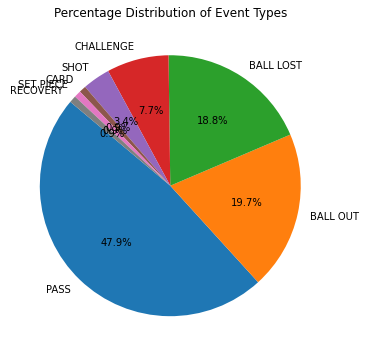

In [13]:
# Pie Chart for percentage distribution of event types
event_type_counts = home_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Fill NA values in Subtype and To columns

In [14]:
# Imputing missing values with 'Unknown'
home_event['Subtype'].fillna('Unknown', inplace=True)
home_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = home_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

Players Involvement In Leading Events for Home 

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


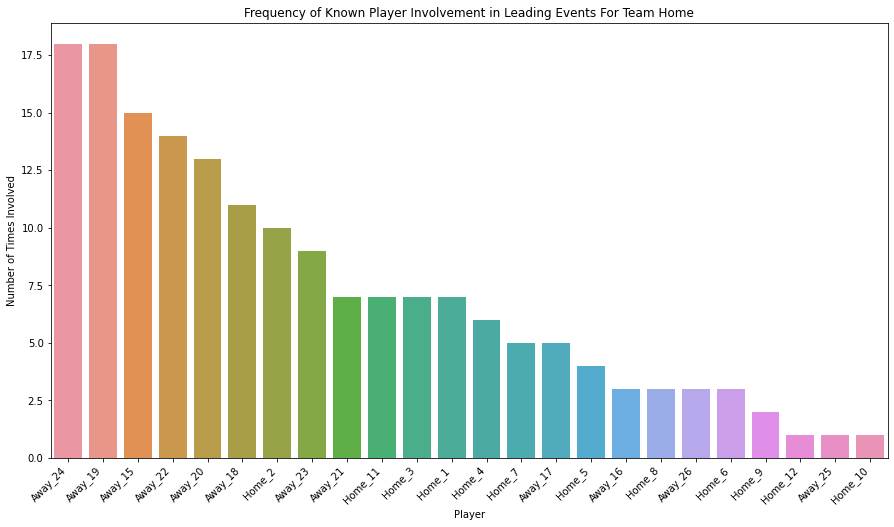

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'home_event' is your DataFrame
combined_players = home_event['From'].append(home_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

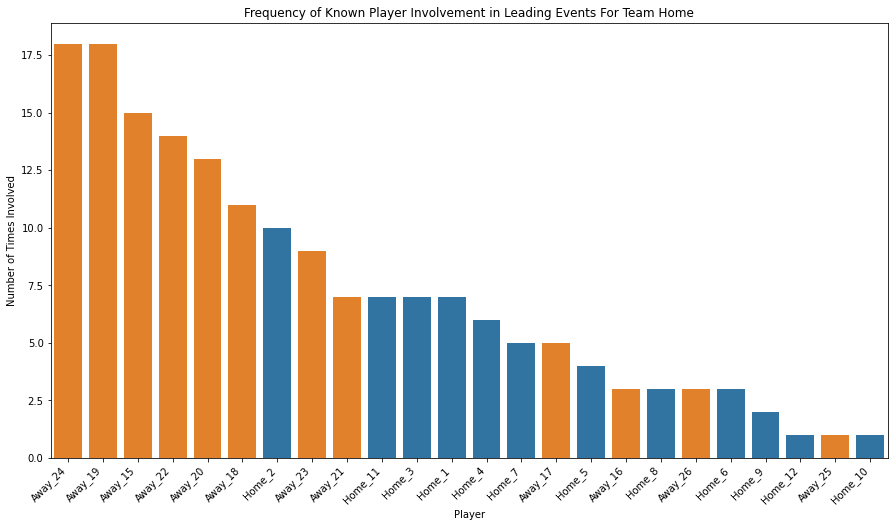

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'home_event' is your DataFrame
combined_players = home_event['From'].append(home_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

### Clustering Process

##### Data Preparation

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Selecting the relevant columns for clustering
features = home_event[['Type', 'Subtype', 'From', 'To']]

# Applying one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Type_BALL LOST,Type_BALL OUT,Type_CARD,Type_CHALLENGE,Type_PASS,Type_RECOVERY,Type_SET PIECE,Type_SHOT,Subtype_AERIAL-LOST,Subtype_CLEARANCE,Subtype_CROSS,Subtype_GROUND,Subtype_GROUND-FAULT-LOST,Subtype_GROUND-LOST,Subtype_GROUND-WON,Subtype_HEAD,Subtype_HEAD-CLEARANCE,Subtype_HEAD-INTERCEPTION,Subtype_INTERCEPTION,Subtype_OFF TARGET-HEAD-OUT,Subtype_OFF TARGET-OUT,Subtype_TACKLE-LOST,Subtype_THROW IN,Subtype_Unknown,Subtype_YELLOW,From_Player 26,From_Player1,From_Player10,From_Player11,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player24,From_Player25,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9,To_Player 26,To_Player1,To_Player11,To_Player12,To_Player15,To_Player18,To_Player19,To_Player2,To_Player20,To_Player22,To_Player23,To_Player24,To_Player3,To_Player7,To_Unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Clustering K-Means

In [18]:
from sklearn.cluster import KMeans

# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

# Adding the cluster labels to the original dataframe
home_event['Cluster'] = clusters

# Displaying a few rows of the dataframe with cluster labels
home_event.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Cluster
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,0.72,0.04,0.87,0.13,3
1,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,0.72,0.04,0.87,0.13,3
2,Home,PASS,Unknown,1,2511,100.44,2546,101.84,Player4,Player3,0.61,0.97,0.76,0.87,2
3,Home,PASS,Unknown,1,3248,129.92,3311,132.44,Player3,Player11,0.58,0.27,0.86,0.45,2
4,Away,PASS,Unknown,1,14189,567.56,14234,569.36,Player15,Player19,0.62,0.99,0.75,0.86,4


##### Analysis of clusters

In [19]:
# Analyzing each cluster
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = home_event[home_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = cluster_data['Type'].value_counts().head(3)
    
    # Most common 'From' players in this cluster
    common_from_players = cluster_data['From'].value_counts().head(3)
    
    # Most common 'To' players in this cluster
    common_to_players = cluster_data['To'].value_counts().head(3)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Display the analysis for each cluster
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,CHALLENGE 9 SHOT 4 CARD 1 N...,Player18 2 Player23 2 Player1 2 Name...,"Unknown 15 Name: To, dtype: int64"
1,BALL OUT 23 BALL LOST 5 RECOVERY ...,Player17 4 Player22 4 Player24 3 Name...,"Unknown 29 Name: To, dtype: int64"
2,"PASS 46 Name: Type, dtype: int64",Player20 5 Player15 5 Player4 4 Name...,Player24 10 Player11 6 Player2 6 N...
3,"BALL LOST 17 Name: Type, dtype: int64",Player24 4 Player20 2 Player16 2 Name...,"Unknown 17 Name: To, dtype: int64"
4,"PASS 10 Name: Type, dtype: int64",Player15 4 Player21 2 Player22 2 Name...,"Player19 10 Name: To, dtype: int64"


##### Visualize clusters

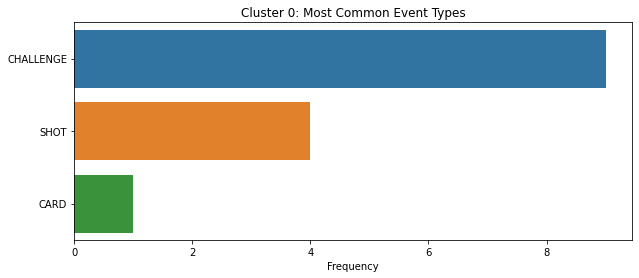

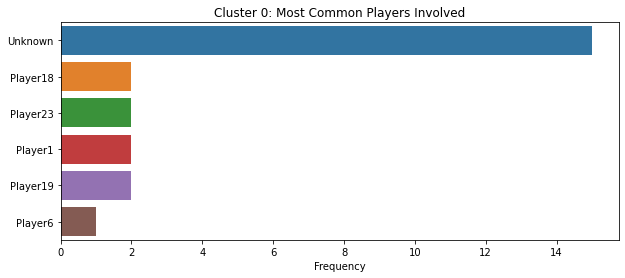

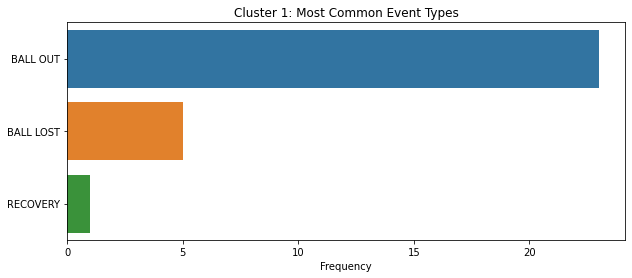

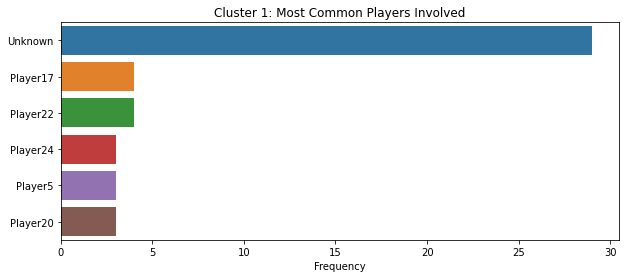

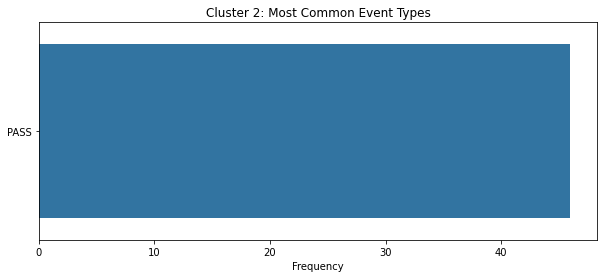

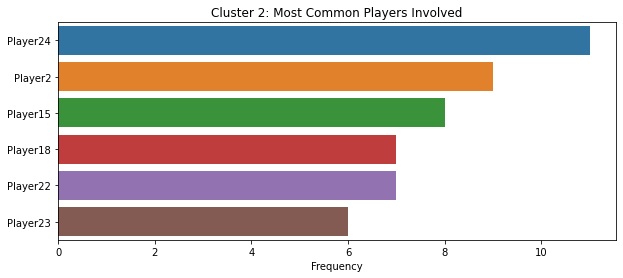

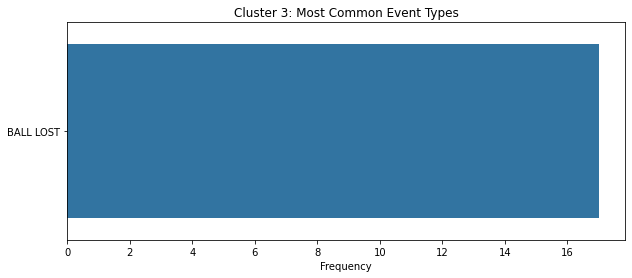

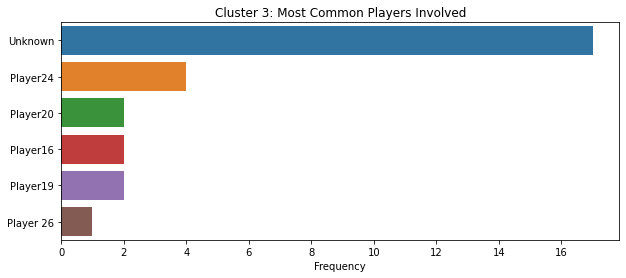

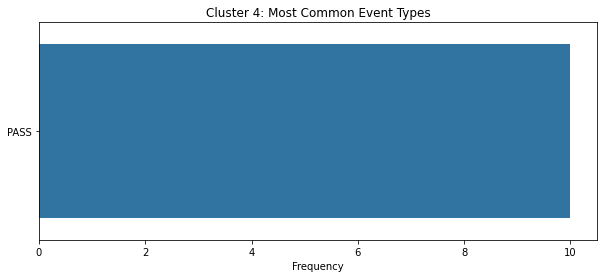

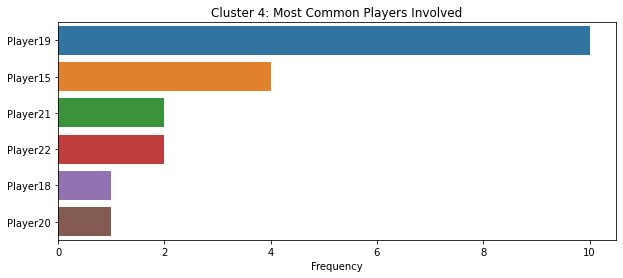

In [20]:
import seaborn as sns

def plot_cluster_data(cluster_num, cluster_data, title):
    """
    Plot the data for a given cluster.
    """
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Cluster {cluster_num}: {title}")
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

# Plotting the most common event types and players for each cluster
for cluster_num in range(5):
    cluster = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types
    common_types = cluster['Type'].value_counts().head(3)
    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')

    # Combining 'From' and 'To' players for a comprehensive view
    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)
    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

Find Away Team High Pressure moment #1

In [21]:
away_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1))]
away_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [22]:
away_moments.to_csv('away_moments.csv', index=False)

Find the exact event before the high pressure moment happen

In [23]:
away_event = pd.DataFrame(columns=events.columns)

for index, row in away_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            home_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= home_time and previous_start_time < home_time:
                away_event = away_event.append(events.iloc[e_index - 1], ignore_index=True)

away_event
away_event.to_csv('away_event.csv', index=False)

Visualize Leading Events for Team Away

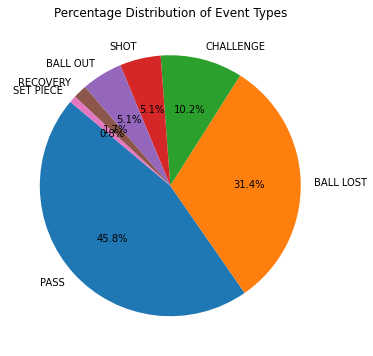

In [24]:
# Pie Chart for percentage distribution of event types
event_type_counts = away_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Fill NA values in Subtype and To columns

In [25]:
# Imputing missing values with 'Unknown'
away_event['Subtype'].fillna('Unknown', inplace=True)
away_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = away_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

Players Involvement In Leading Events for Away 

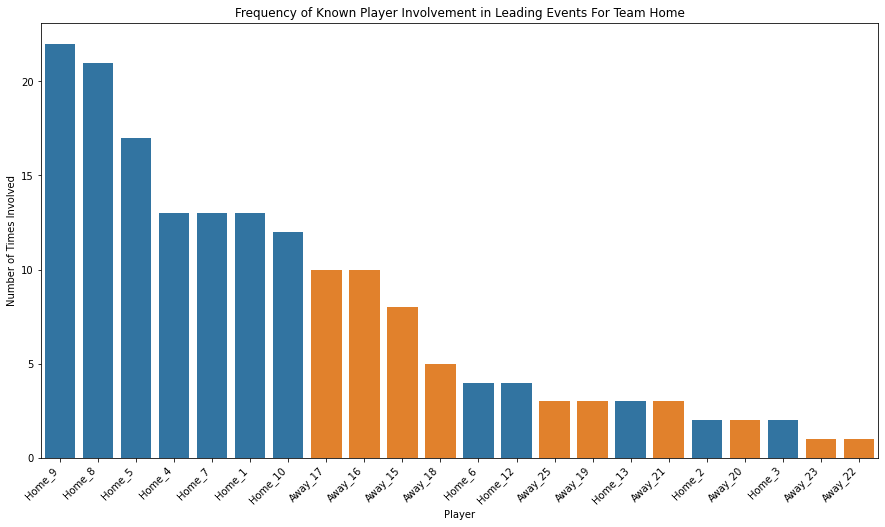

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'home_event' is your DataFrame
combined_players = away_event['From'].append(away_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

### Clustering Process

##### Data Preparation

In [27]:
from sklearn.preprocessing import OneHotEncoder

# Selecting the relevant columns for clustering
features = away_event[['Type', 'Subtype', 'From', 'To']]

# Applying one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Type_BALL LOST,Type_BALL OUT,Type_CHALLENGE,Type_PASS,Type_RECOVERY,Type_SET PIECE,Type_SHOT,Subtype_AERIAL-FAULT-LOST,Subtype_AERIAL-LOST,Subtype_CROSS-INTERCEPTION,Subtype_DEEP BALL,Subtype_FORCED,Subtype_FREE KICK,Subtype_GROUND-FAULT-WON,Subtype_GROUND-LOST,Subtype_GROUND-WON,Subtype_HAND BALL,Subtype_HEAD-INTERCEPTION,Subtype_HEAD-OFF TARGET-OUT,Subtype_INTERCEPTION,Subtype_OFF TARGET-OUT,Subtype_OFFSIDE,Subtype_ON TARGET-SAVED,Subtype_TACKLE-LOST,Subtype_THEFT,Subtype_Unknown,From_Player1,From_Player10,From_Player12,From_Player13,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player25,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9,To_Player1,To_Player10,To_Player12,To_Player16,To_Player17,To_Player19,To_Player20,To_Player21,To_Player25,To_Player5,To_Player7,To_Player8,To_Player9,To_Unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Clustering K-Means

In [28]:
from sklearn.cluster import KMeans

# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

# Adding the cluster labels to the original dataframe
away_event['Cluster'] = clusters

# Displaying a few rows of the dataframe with cluster labels
away_event.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Cluster
0,Away,PASS,Unknown,1,768,30.72,808,32.32,Player16,Player17,0.29,0.84,0.23,0.53,0
1,Away,PASS,Unknown,1,956,38.24,1016,40.64,Player15,Player16,0.28,0.99,0.15,0.90,0
2,Home,BALL LOST,INTERCEPTION,1,2997,119.88,3037,121.48,Player1,Unknown,0.34,0.04,0.19,0.29,1
3,Home,PASS,Unknown,1,3828,153.12,3875,155.00,Player8,Player7,0.28,0.94,0.15,0.93,0
4,Home,PASS,Unknown,1,4132,165.28,4177,167.08,Player5,Player1,0.31,0.55,0.21,0.07,0


##### Analysis of clusters

In [29]:
# Analyzing each cluster
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = away_event[away_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = cluster_data['Type'].value_counts().head(3)
    
    # Most common 'From' players in this cluster
    common_from_players = cluster_data['From'].value_counts().head(3)
    
    # Most common 'To' players in this cluster
    common_to_players = cluster_data['To'].value_counts().head(3)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Display the analysis for each cluster
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,"PASS 54 Name: Type, dtype: int64",Player5 8 Player4 6 Player15 6 Name...,Player8 11 Player1 8 Player9 7 Name...
1,BALL LOST 27 RECOVERY 1 SET PIECE ...,Player5 6 Player9 5 Player8 4 Name: F...,"Unknown 29 Name: To, dtype: int64"
2,"CHALLENGE 12 Name: Type, dtype: int64",Player10 3 Player16 2 Player21 1 Name...,"Unknown 12 Name: To, dtype: int64"
3,BALL LOST 10 BALL OUT 6 RECOVERY ...,Player1 2 Player9 2 Player10 2 Name...,"Unknown 17 Name: To, dtype: int64"
4,"SHOT 6 Name: Type, dtype: int64",Player9 3 Player5 1 Player7 1 Name: F...,"Unknown 6 Name: To, dtype: int64"


##### Visualize clusters

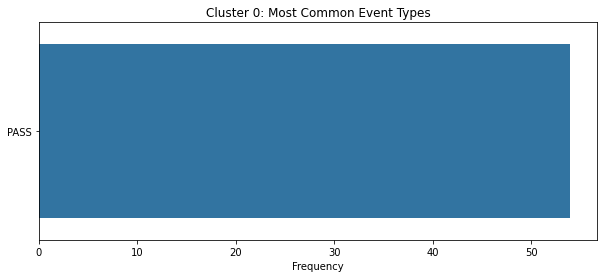

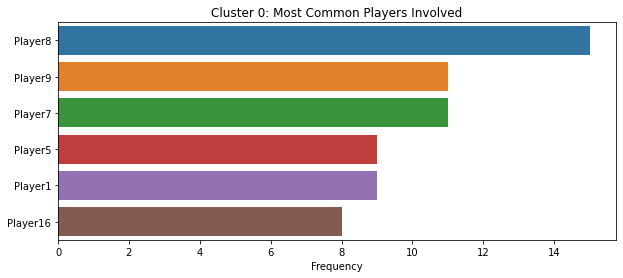

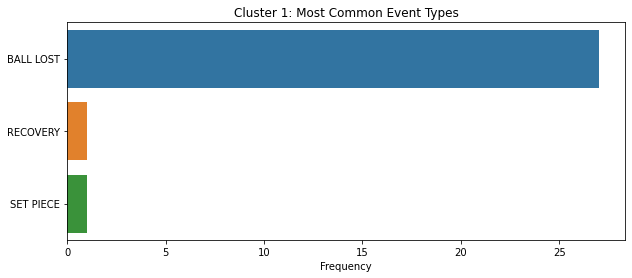

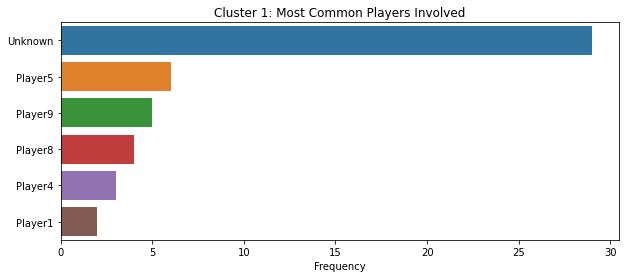

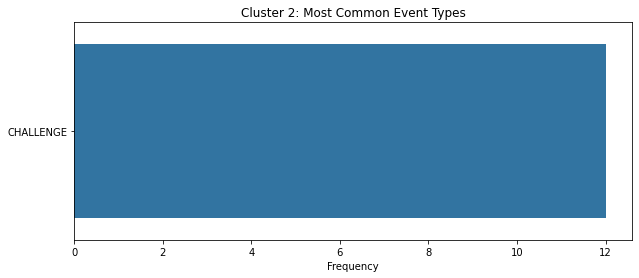

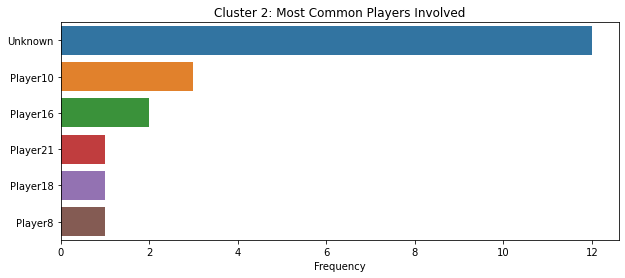

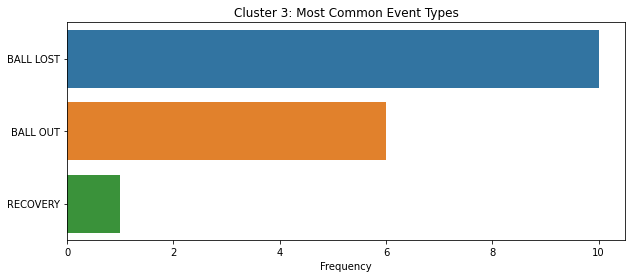

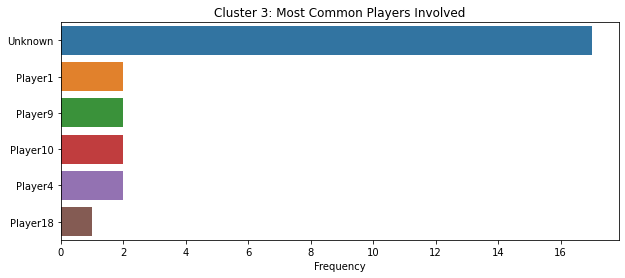

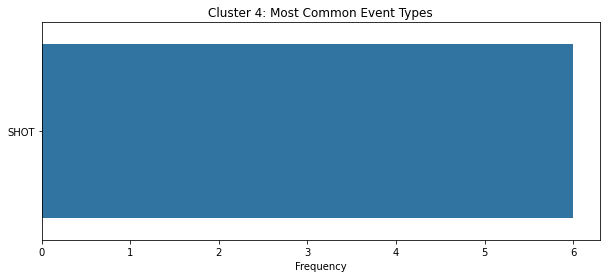

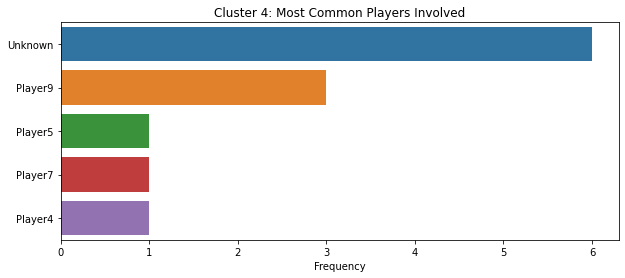

In [30]:
import seaborn as sns

def plot_cluster_data(cluster_num, cluster_data, title):
    """
    Plot the data for a given cluster.
    """
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Cluster {cluster_num}: {title}")
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

# Plotting the most common event types and players for each cluster
for cluster_num in range(5):
    cluster = away_event[away_event['Cluster'] == cluster_num]

    # Most common event types
    common_types = cluster['Type'].value_counts().head(3)
    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')

    # Combining 'From' and 'To' players for a comprehensive view
    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)
    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

In [31]:
def find_leading_events(moment_df, events_df, time_window):
    """
    Find up to three events leading up to each moment within a specified time window.

    :param moment_df: DataFrame containing moments for a team.
    :param events_df: DataFrame containing events data.
    :param time_window: Time window in seconds within which to search for leading events.
    :return: DataFrame with the leading events.
    """
    leading_events = []

    for _, moment in moment_df.iterrows():
        period = moment['Period']
        moment_time = moment['Time [s]']

        # Filtering events that are in the same period and within the time window
        valid_events = events_df[
            (events_df['Period'] == period) &
            (events_df['Start Time [s]'] <= moment_time) &
            (events_df['Start Time [s]'] >= moment_time - time_window)
        ]

        # Sort by time descending (most recent first) and take up to 3 events
        valid_events = valid_events.sort_values(by='Start Time [s]', ascending=False).head(3)

        # Add moment identifier columns to each valid event
        valid_events['Moment Period'] = period
        valid_events['Moment Time [s]'] = moment_time

        leading_events.append(valid_events)

    return pd.concat(leading_events, ignore_index=True)

# Define the time window (9 seconds)
time_window = 9

# Find leading events for home moments
leading_events_home = find_leading_events(home_moments, events, time_window)

leading_events_home.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,0.72,0.04,0.87,0.13,1.0,55.96
1,Away,PASS,NaN,1,1289,51.56,1319,52.76,Player18,Player24,0.49,0.18,0.62,0.18,1.0,55.96
2,Home,RECOVERY,INTERCEPTION,1,1431,57.24,1431,57.24,Player1,NaN,0.87,0.13,NaN,NaN,1.0,57.24
3,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,0.72,0.04,0.87,0.13,1.0,57.24
4,Away,PASS,NaN,1,1289,51.56,1319,52.76,Player18,Player24,0.49,0.18,0.62,0.18,1.0,57.24


In [32]:
# Find leading events for away moments
leading_events_away = find_leading_events(away_moments, events, time_window)

leading_events_away.head()


,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,PASS,NaN,1,768,30.72,808,32.32,Player16,Player17,0.29,0.84,0.23,0.53,1.0,31.68
1,Away,SET PIECE,THROW IN,1,672,26.88,672,26.88,Player15,NaN,NaN,NaN,NaN,NaN,1.0,31.68
2,Away,PASS,NaN,1,672,26.88,722,28.88,Player15,Player16,0.50,1.01,0.33,0.92,1.0,31.68
3,Away,PASS,NaN,1,956,38.24,1016,40.64,Player15,Player16,0.28,0.99,0.15,0.90,1.0,38.72
4,Away,PASS,NaN,1,925,37.00,947,37.88,Player16,Player15,0.23,0.87,0.28,0.99,1.0,38.72


In [33]:
def create_event_triples(leading_events_df):
    """
    Create triples of events for each moment.

    :param leading_events_df: DataFrame containing leading events for each moment.
    :return: DataFrame with triples of events for each moment.
    """
    # Group by moment
    grouped = leading_events_df.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        events = group.to_dict('records')
        triple = [events[i] if i < len(events) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['Event 1', 'Event 2', 'Event 3'])

# Create event triples for home and away
triples_home = create_event_triples(leading_events_home)
triples_away = create_event_triples(leading_events_away)

triples_home.head(), triples_away.head()

(                                             Event 1  \
 0  {'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...   
 1  {'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'...   
 2  {'Team': 'Home', 'Type': 'PASS', 'Subtype': na...   
 3  {'Team': 'Home', 'Type': 'PASS', 'Subtype': na...   
 4  {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...   
 
                                              Event 2  \
 0  {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...   
 1  {'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...   
 2  {'Team': 'Home', 'Type': 'PASS', 'Subtype': na...   
 3  {'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'...   
 4  {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...   
 
                                              Event 3  
 0                                               None  
 1  {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...  
 2  {'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'...  
 3  {'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...  
 4  {'Team': 'Away', 'Type': 'PA

In [34]:
# Re-define the create_event_triples function to include only the 'Type' of each event
def create_event_type_triples(leading_events_df):
    """
    Create triples of event types for each moment.

    :param leading_events_df: DataFrame containing leading events for each moment.
    :return: DataFrame with triples of event types for each moment.
    """
    # Group by moment
    grouped = leading_events_df.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        event_types = group['Type'].tolist()
        triple = [event_types[i] if i < len(event_types) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['1 Event Before', '2 Events Before', '3 Events Before'])

# Create event type triples for home and away
type_triples_home = create_event_type_triples(leading_events_home)
type_triples_away = create_event_type_triples(leading_events_away)

type_triples_home.head(), type_triples_away.head()


(  1 Event Before 2 Events Before 3 Events Before
 0      BALL LOST            PASS            None
 1       RECOVERY       BALL LOST            PASS
 2           PASS            PASS        RECOVERY
 3           PASS        RECOVERY       BALL LOST
 4           PASS            PASS            PASS,
   1 Event Before 2 Events Before 3 Events Before
 0           PASS       SET PIECE            PASS
 1           PASS            PASS            PASS
 2      BALL LOST            PASS            PASS
 3           PASS            PASS            PASS
 4           PASS            PASS            PASS)

In [38]:
type_triples_home.to_csv("type_triples_home.csv")

In [39]:
type_triples_away.to_csv("type_triples_away.csv")

In [40]:
# Frequency analysis for each event position in both datasets
freq_home_1 = type_triples_home['1 Event Before'].value_counts()
freq_home_2 = type_triples_home['2 Events Before'].value_counts()
freq_home_3 = type_triples_home['3 Events Before'].value_counts()

freq_away_1 = type_triples_away['1 Event Before'].value_counts()
freq_away_2 = type_triples_away['2 Events Before'].value_counts()
freq_away_3 = type_triples_away['3 Events Before'].value_counts()

(freq_home_1, freq_home_2, freq_home_3, freq_away_1, freq_away_2, freq_away_3)

(PASS         53
 RECOVERY     25
 SET PIECE    18
 BALL LOST     9
 CHALLENGE     6
 BALL OUT      6
 Name: 1 Event Before, dtype: int64,
 PASS         76
 CHALLENGE    12
 BALL LOST    10
 RECOVERY     10
 SET PIECE     3
 SHOT          2
 BALL OUT      1
 Name: 2 Events Before, dtype: int64,
 PASS              41
 CHALLENGE         13
 BALL LOST         12
 RECOVERY           6
 SET PIECE          2
 BALL OUT           2
 FAULT RECEIVED     1
 Name: 3 Events Before, dtype: int64,
 PASS         51
 RECOVERY     29
 SET PIECE    15
 CHALLENGE    12
 BALL LOST    11
 Name: 1 Event Before, dtype: int64,
 PASS         64
 BALL LOST    22
 RECOVERY     16
 CHALLENGE     9
 SET PIECE     3
 SHOT          2
 Name: 2 Events Before, dtype: int64,
 PASS         51
 BALL LOST    13
 CHALLENGE    12
 RECOVERY      7
 SET PIECE     2
 BALL OUT      2
 SHOT          1
 Name: 3 Events Before, dtype: int64)

In [44]:
from collections import Counter

# Function to count sequences
def count_sequences(df):
    sequences = df.apply(lambda row: tuple(row.dropna().values), axis=1)
    return Counter(sequences)

# Counting sequences for home and away datasets
sequence_counts_home = count_sequences(type_triples_home.iloc[:, 1:])
sequence_counts_away = count_sequences(type_triples_away.iloc[:, 1:])

# Displaying the most common sequences
most_common_home = sequence_counts_home.most_common(5)
most_common_away = sequence_counts_away.most_common(5)

most_common_home, most_common_away

([(('PASS',), 29),
  (('PASS', 'PASS'), 29),
  (('PASS', 'BALL LOST'), 6),
  (('BALL LOST',), 6),
  (('CHALLENGE', 'CHALLENGE'), 6)],
 [(('PASS', 'PASS'), 40),
  (('PASS',), 13),
  (('BALL LOST',), 11),
  (('PASS', 'CHALLENGE'), 4),
  (('RECOVERY', 'BALL LOST'), 4)])

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


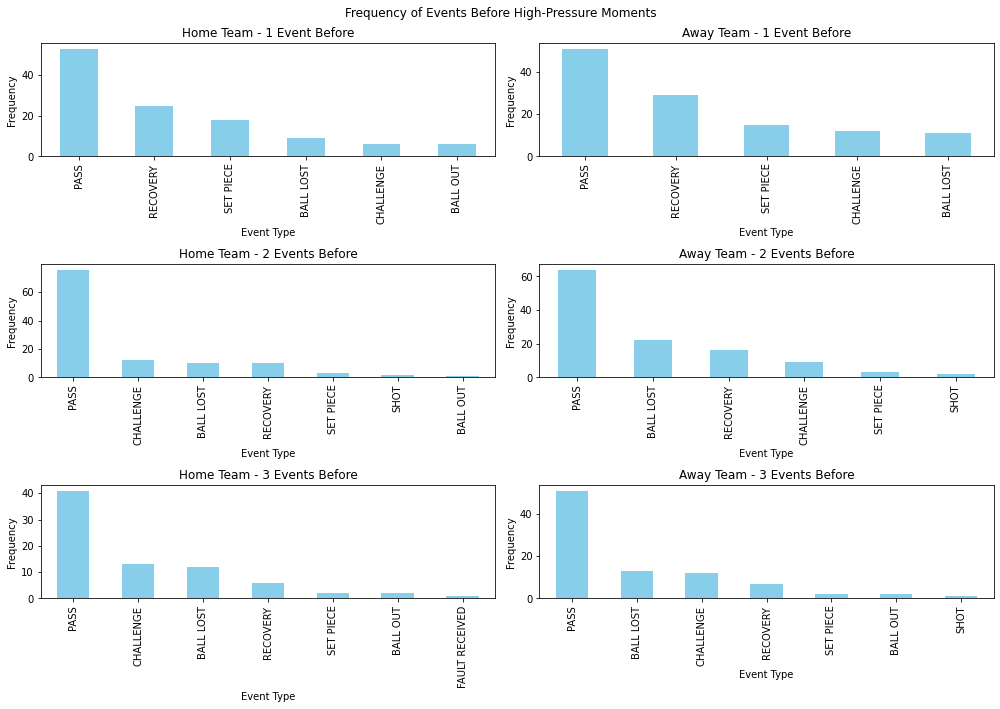

In [45]:
import matplotlib.pyplot as plt

# Function to plot frequency bar charts
def plot_event_frequencies(freq_data, title, ax):
    freq_data.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Event Type')

# Creating subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10), tight_layout=True)
fig.suptitle('Frequency of Events Before High-Pressure Moments')

# Plotting for Home Team
plot_event_frequencies(freq_home_1, 'Home Team - 1 Event Before', axes[0, 0])
plot_event_frequencies(freq_home_2, 'Home Team - 2 Events Before', axes[1, 0])
plot_event_frequencies(freq_home_3, 'Home Team - 3 Events Before', axes[2, 0])

# Plotting for Away Team
plot_event_frequencies(freq_away_1, 'Away Team - 1 Event Before', axes[0, 1])
plot_event_frequencies(freq_away_2, 'Away Team - 2 Events Before', axes[1, 1])
plot_event_frequencies(freq_away_3, 'Away Team - 3 Events Before', axes[2, 1])

plt.show()

#### SEPRATING PERIODS For Home

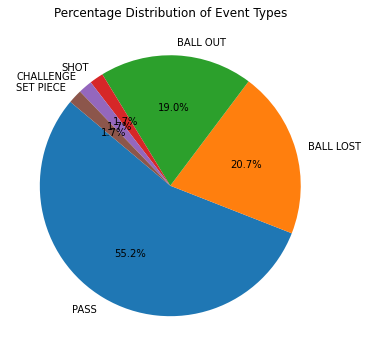

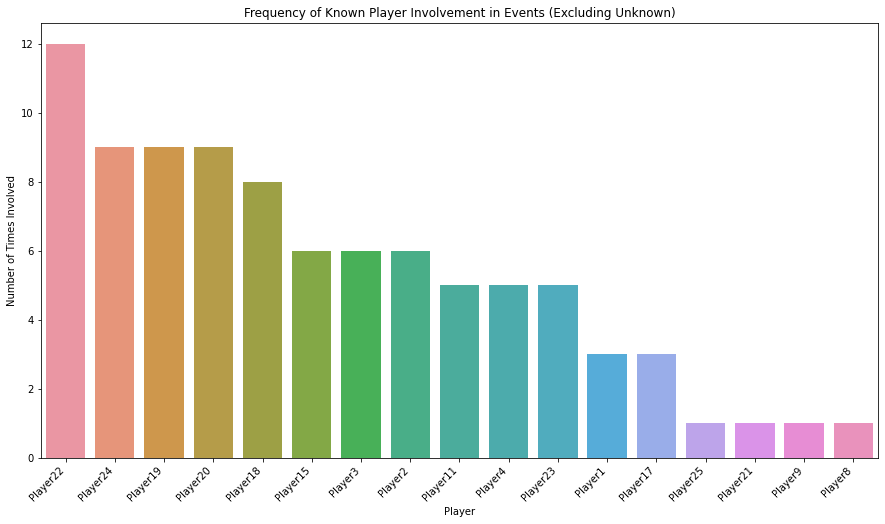

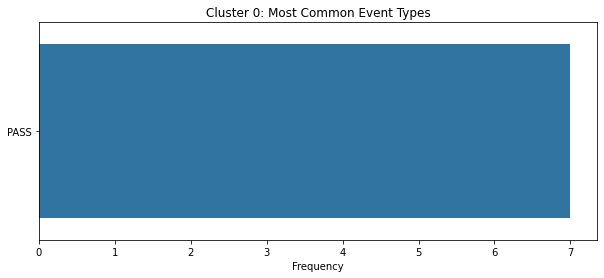

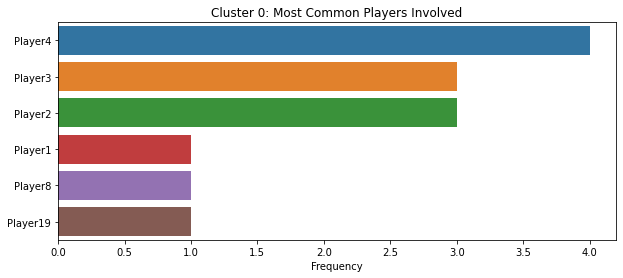

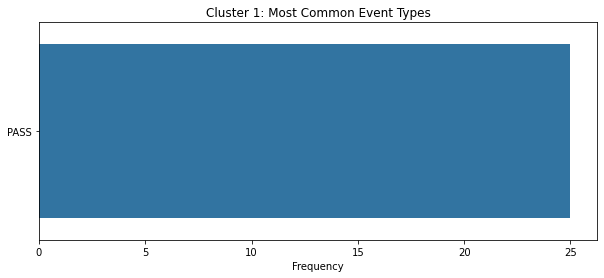

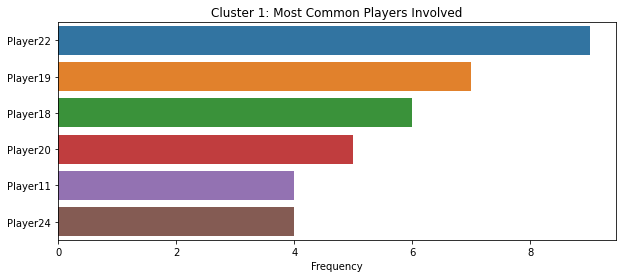

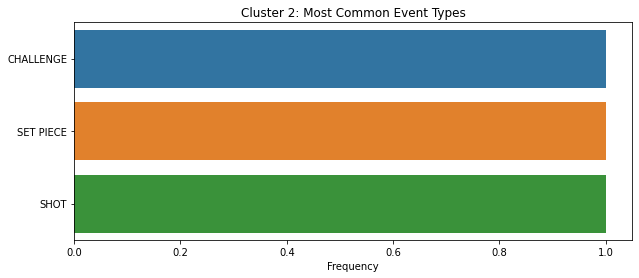

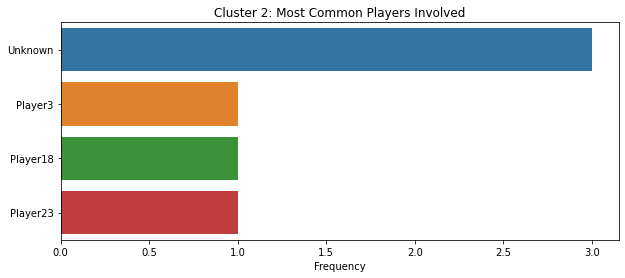

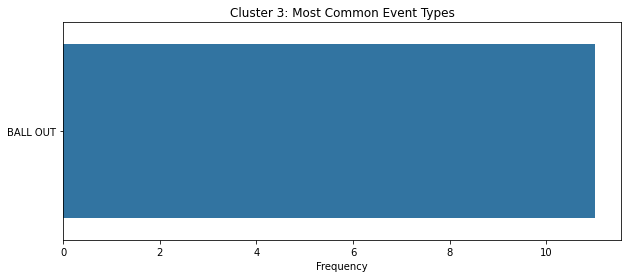

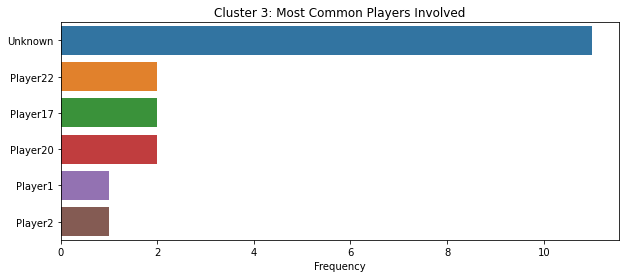

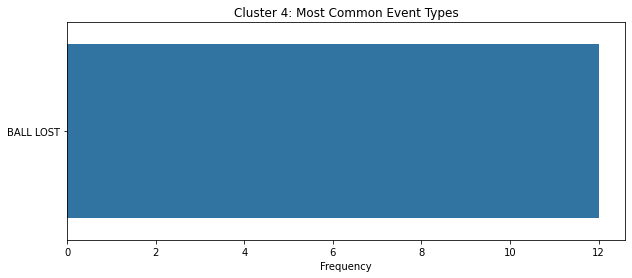

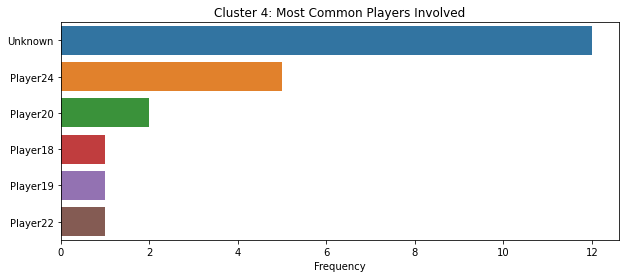

In [36]:

home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1))]

home_moments.columns


import numpy as np
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


home_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = home_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


home_event['Subtype'].fillna('Unknown', inplace=True)

home_event['To'].fillna('Unknown', inplace=True)

imputation_check = home_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = home_event['From'].append(home_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = home_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

home_event['Cluster'] = clusters

home_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = home_event[home_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


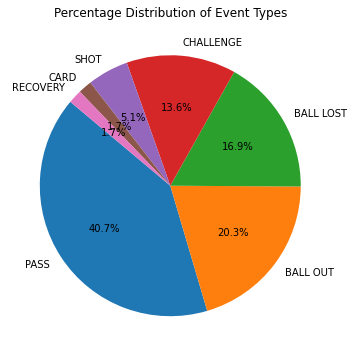

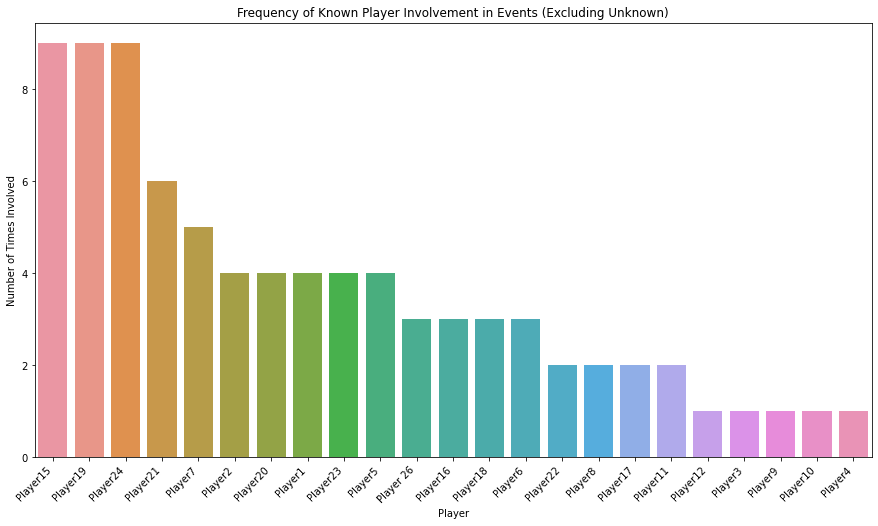

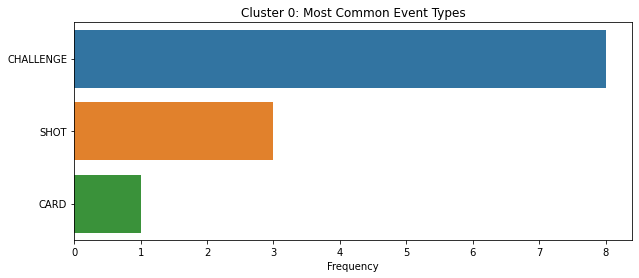

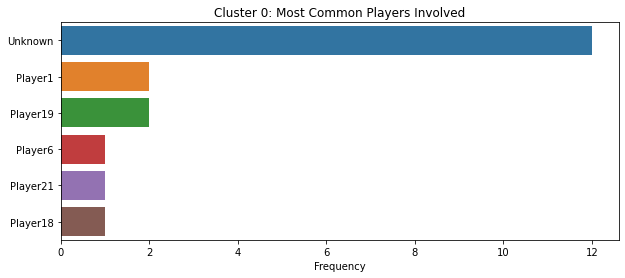

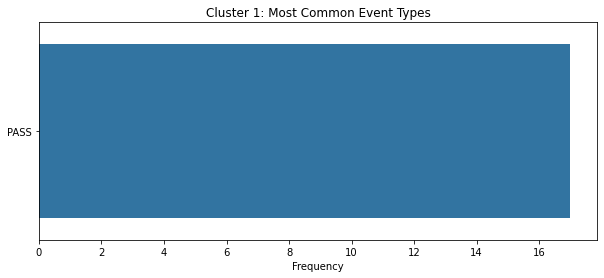

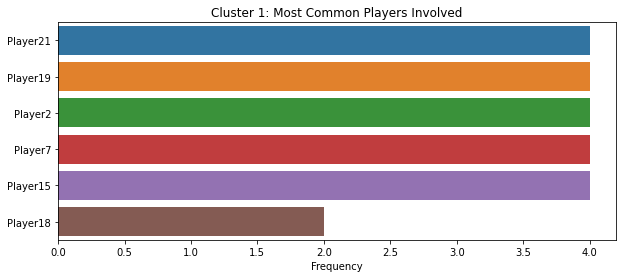

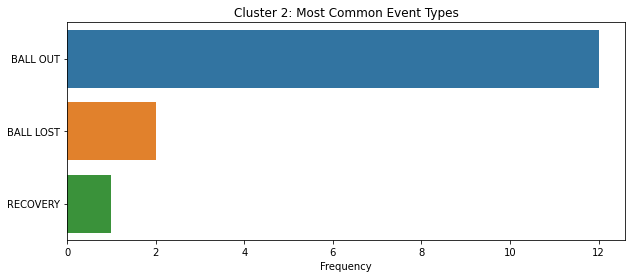

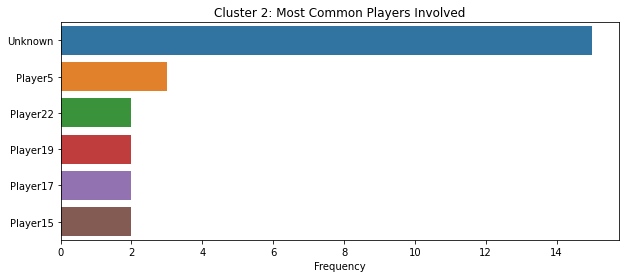

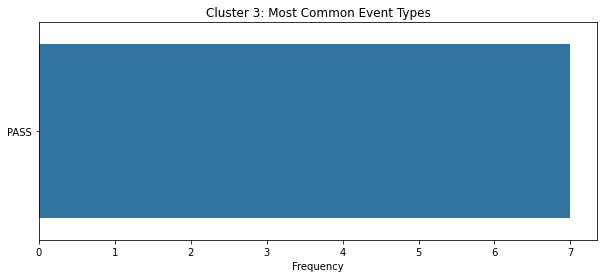

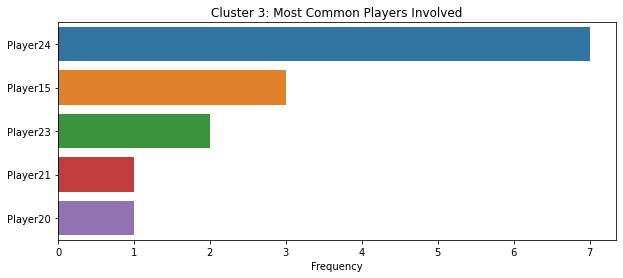

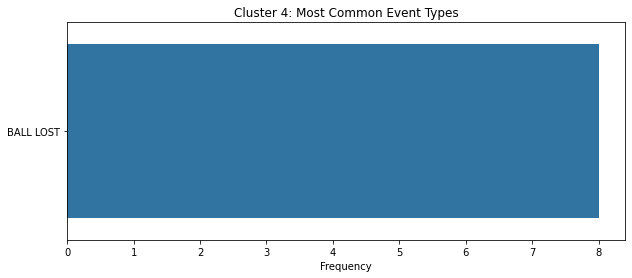

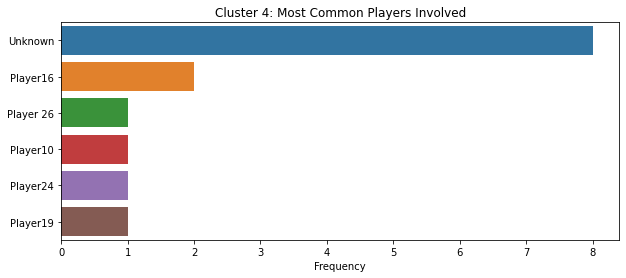

In [37]:

home_moments = tracking_data[(tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2)]
home_moments.columns

import numpy as np
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


home_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = home_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


home_event['Subtype'].fillna('Unknown', inplace=True)

home_event['To'].fillna('Unknown', inplace=True)

imputation_check = home_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = home_event['From'].append(home_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = home_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

home_event['Cluster'] = clusters

home_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = home_event[home_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')